In [1]:
%cd /data/codes/prep_ps_pykaldi

import pandas as pd
import os
from glob import glob
import json
from pandarallel import pandarallel
import random
import re

pandarallel.initialize(nb_workers=10, progress_bar=True)

/data/codes/prep_ps_pykaldi
INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
audio_dir = "/data/audio_data/prep_submission_audio/12"
metadata_path="/data/audio_data/pronunciation_scoring_result/dataset/info_out_domain_long_sentence_testset.csv"
metadata = pd.read_csv(metadata_path)
metadata.dropna(inplace=True)
metadata.head(20)

,id,is_deleted,user_id,question_id,question_type,question_content,url,score,fidelity_class,created_at,total_time,word_count
0,5583482,0,189760.0,156698,12,I have a carrot and a banana.,https://storage.googleapis.com/materials-eleme...,85.78,RELEVANT,2023-09-18 22:02:30,4.08,7.0
1,5583510,0,189760.0,156699,12,The atlas contains a lot of maps.,https://storage.googleapis.com/materials-eleme...,63.59,RELEVANT,2023-09-18 22:02:48,4.28,7.0
2,5583531,0,189760.0,156700,12,He talked about his illness.,https://storage.googleapis.com/materials-eleme...,47.02,RELEVANT,2023-09-18 22:03:03,3.42,5.0
3,5583561,0,189760.0,156701,12,Father went around the apartment.,https://storage.googleapis.com/materials-eleme...,71.89,RELEVANT,2023-09-18 22:03:18,3.62,5.0
4,5583596,0,189760.0,156702,12,The company will supply the telephones.,https://storage.googleapis.com/materials-eleme...,62.57,RELEVANT,2023-09-18 22:03:34,4.40,6.0
5,5583622,0,189760.0,156703,12,I was sitting alone on the sofa.,https://storage.googleapis.com/materials-eleme...,63.64,RELEVANT,2023-09-18 22:03:50,3.86,7.0
6,5583641,0,189760.0,156705,12,The performance in the circus was amazing.,https://storage.googleapis.com/materials-eleme...,54.44,RELEVANT,2023-09-18 22:04:05,4.38,7.0
7,5583656,0,189760.0,156706,12,He suggested a system.,https://storage.googleapis.com/materials-eleme...,50.16,RELEVANT,2023-09-18 22:04:18,2.76,4.0
8,4141433,0,181790.0,125219,12,He's painting a portion of the wall.,https://storage.googleapis.com/materials-eleme...,65.39,RELEVANT,2023-07-23 23:47:44,4.67,7.0
9,4141439,0,181790.0,125220,12,He's repositioning a stepladder.,https://storage.googleapis.com/materials-eleme...,79.95,RELEVANT,2023-07-23 23:48:04,5.19,4.0


In [47]:
def check_audio_is_exist(audio_id):
    abs_path = os.path.join(audio_dir, f'{audio_id}.wav')
    if os.path.exists(abs_path):
        return True
    return False

metadata["is_exist"] =  metadata.id.parallel_apply(check_audio_is_exist)
print(metadata.shape)
metadata = metadata[metadata["is_exist"] == True]
print(metadata.shape)

(34285, 13)
(34284, 13)


<Axes: >

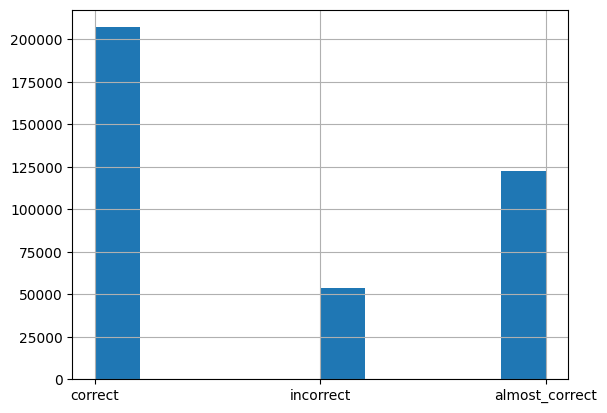

In [48]:
def get_decision(json_path):
    with open(json_path, "r") as f:
        raw_sample = json.load(f)

    if "api_version" not in raw_sample:
        return None
            
    utterance = raw_sample["utterance"][0]    
    decisions = []

    for word in utterance["words"]:
        decisions.append(word["decision"])

    return decisions
    
json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/12"
decisions = metadata.id.parallel_apply(lambda x: get_decision(os.path.join(json_dir, f'{x}.json')))
decisions = decisions.explode()
decisions.hist()

<Axes: >

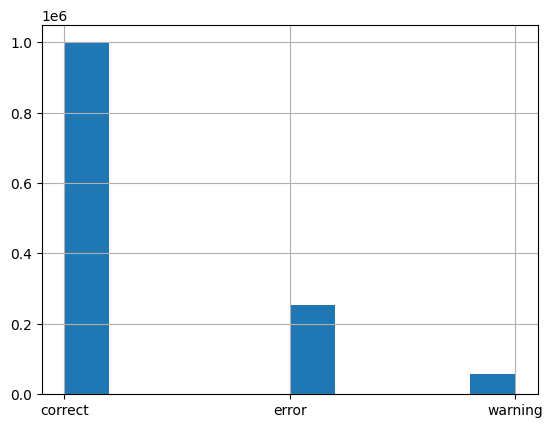

In [49]:
def get_decision(json_path):
    with open(json_path, "r") as f:
        raw_sample = json.load(f)

    if "api_version" not in raw_sample:
        return None
            
    utterance = raw_sample["utterance"][0]    
    decisions = []

    for word in utterance["words"]:
        for phoneme in word["phonemes"]:
            decisions.append(phoneme["decision"])

    return decisions
    
json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/12"
decisions = metadata.id.parallel_apply(lambda x: get_decision(os.path.join(json_dir, f'{x}.json')))
decisions = decisions.explode()
decisions.hist()

<Axes: >

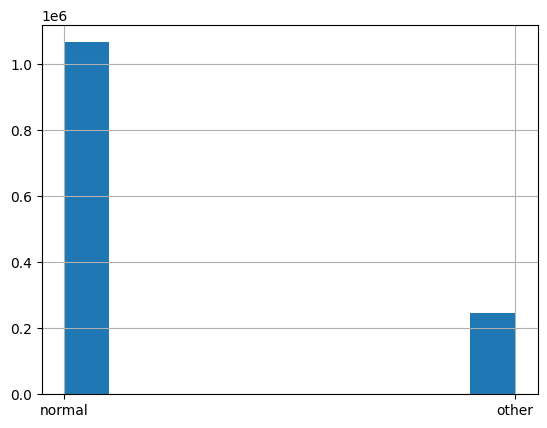

In [50]:
def get_phoneme_error(json_path):
    try:
        with open(json_path, "r") as f:
            raw_sample = json.load(f)

        if "api_version" not in raw_sample:
            return None
                
        utterance = raw_sample["utterance"][0]    
        phoneme_errors = []

        for word in utterance["words"]:
            for phoneme in word["phonemes"]:
                if phoneme["phoneme_error"] == "normal":
                    phoneme_errors.append(phoneme["phoneme_error"])
                elif "-" in phoneme["phoneme_error"]:
                    phoneme_errors.append("other")
                else:
                    phoneme_errors.append(phoneme["phoneme_error"])
                    
        return phoneme_errors
    except:
        return None
    
json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/12"
phoneme_errors = metadata.id.parallel_apply(lambda x: get_phoneme_error(os.path.join(json_dir, f'{x}.json')))
phoneme_errors = phoneme_errors.explode()
phoneme_errors.hist()

In [51]:
def is_valid_phoneme(phoneme):
    if phoneme["phoneme_error_arpabet"] != "normal":
        trans = phoneme["phoneme_error_arpabet"].split(" - ")[-1]
        if len(trans.split(" ")) >= 2:
            return False
    return True

def extract_user_trans(phoneme):
    valid = True
    if phoneme["phoneme_error_arpabet"] != "normal":
        arpa, trans = phoneme["phoneme_error_arpabet"].split(" - ")
        
        try:
            assert arpa == phoneme["trans_arpabet"]
        except:
            valid = False
            # print(phoneme["phoneme_error_arpabet"], phoneme["trans_arpabet"])
    else:
        arpa, trans = phoneme["trans_arpabet"], phoneme["trans_arpabet"]

    return arpa, trans, valid
        
            
def parse_metadata_data(json_path):
    # try:
        with open(json_path, "r") as f:
            raw_sample = json.load(f)

        if "api_version" not in raw_sample:
            return None
        
        assert len(raw_sample["utterance"]) == 1
        
         
        words, phonemes = [], []
        utterance = raw_sample["utterance"][0] 
        for word in utterance["words"]:
                        
            _phonemes, _trans_phonemes = [], []
            for phoneme in word["phonemes"]:
                if not is_valid_phoneme(phoneme):
                    return None
            
                arpa, trans, valid = extract_user_trans(phoneme)
                if valid == False:
                    return None
                text = phoneme["text"]
                # score = phone_decision_to_score[phoneme["decision"]]
                score = phoneme["nativeness_score"]

                _phoneme = {
                    "text": text,
                    "trans": trans,
                    "arpa": arpa,
                    "score": score,
                }
                _phonemes.append(_phoneme)
                _trans_phonemes.append(trans)
            phonemes.append(_phonemes)

            text = word["text"]
            arpa = word["trans_arpabet"]
            trans = " ".join(_trans_phonemes).replace("SCHWA", "AH")
            # score = word_decision_to_score[word["decision"]]
            score = word["nativeness_score"]

            word = {
                "text": text,
                "arpa": arpa,
                "trans": trans,
                "score": score
            }

            words.append(word)
                
        metadata = {
            "words": words,
            "phonemes": phonemes,
            "utterance": utterance["nativeness_score"]
        }

        return json.dumps(metadata, ensure_ascii=False)
    # except:
    #     return None
    
json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/12"
metadata["score"] = metadata.id.parallel_apply(lambda x: parse_metadata_data(os.path.join(json_dir, f'{x}.json')))

print(metadata.shape)
metadata = metadata[metadata["score"].notna()]
print(metadata.shape)

# metadata.head(100000).id.apply(lambda x: parse_metadata_data(os.path.join(json_dir, f'{x}.json')))

(34284, 13)
(19598, 13)


<Axes: >

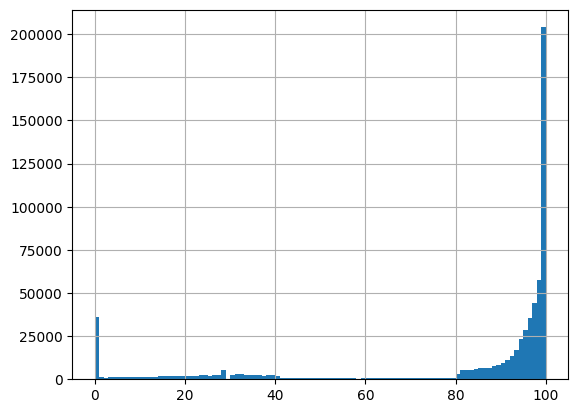

In [52]:
def get_phone_score(score):
    phone_scores = []
    score = json.loads(score)
    for words in score["phonemes"]:
        for phoneme in words:
            phone_scores.append(phoneme["score"])

    return phone_scores

tmp = metadata.score.apply(lambda x: get_phone_score(x))
tmp = tmp.explode()
tmp.hist(bins=100)

<Axes: >

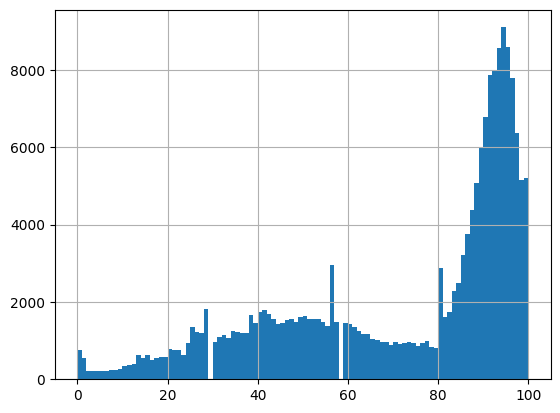

In [53]:
def get_word_score(score):
    word_scores = []
    score = json.loads(score)
    for words in score["words"]:
        word_scores.append(words["score"])

    return word_scores

tmp = metadata.score.parallel_apply(lambda x: get_word_score(x))
tmp = tmp.explode()
tmp.hist(bins=100)

<Axes: >

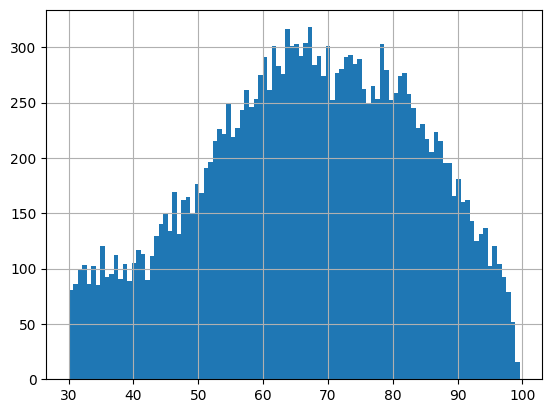

In [54]:
def get_sent_score(score):
    score = json.loads(score)["utterance"]

    return score

tmp = metadata.score.parallel_apply(lambda x: get_sent_score(x))
tmp.hist(bins=100)

In [55]:
def preprocess_text(text):
    text = re.sub("[\,\.\;\:\!\?]", " ", text)
    text = text.upper()
    text = text.strip()
    return text
metadata["question_content"] = metadata.question_content.apply(preprocess_text)

In [56]:
# lexicon_path = "resources/lexicon.txt"
# lexicon = pd.read_csv(lexicon_path, sep="\t", names=["word", "arpa"])
# lexicon.head()

# vocab = {}
# for index in lexicon.index:
#     word = lexicon["word"][index]
#     arpa = lexicon["arpa"][index]

#     if word not in vocab:
#         vocab[word] = [arpa, ]
#     else:
#         vocab[word].append(arpa)


In [57]:
lexicon_path = "resources/lexicon.txt"
vocab = {}
with open(lexicon_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
    lines.reverse()
    lines = [line.strip().split() for line in lines]
    lines = [[line[0], " ".join(line[1:])] for line in lines]
    
    for word, phoneme in lines:
        vocab[word] = phoneme
        

In [58]:
def filter_data(text, words):
    words = json.loads(words)["words"]
    if len(text.split()) != len(words):
        return False
    for word, phoneme in zip(text.upper().split(), words):
        if word not in vocab:
            return False
        if phoneme["arpa"] not in vocab[word]:
            return False
    
    return True
metadata["is_selected"] = metadata.apply(lambda x: filter_data(x["question_content"], x["score"]), axis=1)
print(metadata.shape)
metadata = metadata[metadata["is_selected"]==True].reset_index()
print(metadata[metadata["is_selected"]==True].shape)


(19598, 14)
(1317, 15)


In [59]:
# metadata[["user_id", "id", "question_content", "score", "question_id"]].to_csv("/data/codes/prep_ps_pykaldi/prep_data/raw/info_out_domain_short_sentence_testset.csv")
metadata[["user_id", "id", "question_content", "score", "question_id"]].to_csv("/data/codes/prep_ps_pykaldi/prep_data/raw/info_out_domain_long_sentence_testset_old.csv")